In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json, pickle, glob

import matplotlib.pyplot as plt
from src.utils.plotting.car_plotting import plot_cars, plot_multiple_cars

In [2]:
sim_dirs = glob.glob('/home/nbuckman/mpc_results/rl_results_11152021/results/*-*')
print("# Sim Dirs: %d"%len(sim_dirs))

# Sim Dirs: 160


In [3]:
CONV_MS_TO_MPH = 2.23694
all_params = []
all_trajs = []
all_vehicles = []
all_dirs = []

for sim_dir in sim_dirs:
    params_path = glob.glob(sim_dir + '/params.json')
    trajs_path = glob.glob(sim_dir + '/trajectories.npy')
    vehicles_path = glob.glob(sim_dir + '/other_vehicles.p')
    
    if len(trajs_path) > 0:
        all_params += [json.load(open(params_path[0],'rb'))]
        all_trajs += [np.load(trajs_path[0])]
        all_vehicles += [pickle.load(open(vehicles_path[0],'rb'))]
        all_dirs += [sim_dir]
print("# Simulations: %d"%len(all_dirs))

# Simulations: 113


In [4]:
print("Max MPC_END: %d"%(all_trajs[0].shape[2]-1))
n_mpc_end = 500

Max MPC_END: 500


In [5]:
params = all_params[0]
total_time = params["T"] * params['p_exec'] * params['n_mpc']
total_time = params["dt"] * n_mpc_end
print("Total Sim Time", total_time)

Total Sim Time 100.0


In [6]:
all_trajs[0].shape

(10, 6, 501)

# Experiment Describer

<ipython-input-7-a4b5c72c80dd>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


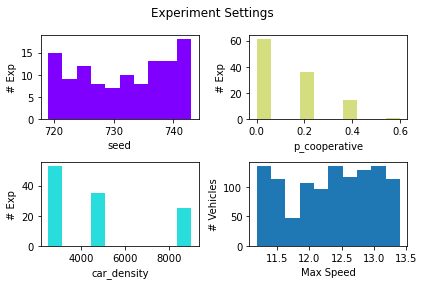

In [7]:
all_seeds = [param["seed"] for param in all_params]
all_densities = [param["car_density"] for param in all_params]
all_p_cooperative = [param["p_cooperative"] for param in all_params]

fig, axs = plt.subplots(2,2)

color=iter(plt.cm.rainbow(np.linspace(0,1,4)))
counter = 0
for param_key in ["seed", "car_density", "p_cooperative"]:
    row = counter%2
    col = counter // 2
    ax = axs[row, col]
    all_p_key = [param[param_key] for param in all_params]
    c = next(color)
    ax.hist(all_p_key, facecolor=c)
    ax.set_xlabel(param_key)
    ax.set_ylabel("# Exp")
    counter+=1

    
    
c = next(color)    
all_max_speeds = [veh.max_v for vehicles in all_vehicles for veh in vehicles ]
axs[1,1].hist(all_max_speeds)
axs[1,1].set_xlabel('Max Speed')
axs[1,1].set_ylabel('# Vehicles')
fig.suptitle("Experiment Settings")

fig.tight_layout()
fig.show()

In [8]:
def n_vehicles_behind(x_array):
    ''' Input: [n_veh x 1] array of x-positions
        Output: [n_veh x 1] array of # of vehicles behind vehicle i
    '''
    final_distance = np.tile(x_array, (10,1))    
    n_vehicles = np.sum(final_distance.T > final_distance, axis=1)
    return n_vehicles

# Check for Collisions

In [9]:
def check_collision_experiment(traj):
    ''' Check for collision in experiment
        If coollision occurs, the trajectory will be zeros(1,6)
    '''
    if np.any(np.all(traj[:,:,1:] == np.zeros((1, 6, 1)), axis=1)):
        return True
    return False

In [10]:
distances_array = np.array([all_trajs[exi][:,0,n_mpc_end] - all_trajs[exi][:,0,0] for exi in range(len(all_params))])
total_distance_meters = np.sum(distances_array)
total_collisions = np.sum([check_collision_experiment(traj) for traj in all_trajs])
total_experiments = len(all_trajs)
percentage_collisions_experiments = float(total_collisions) / total_experiments
collisions_per_km = float(total_collisions) / (total_distance_meters / 1000.0) 
collisions_per_bkm = collisions_per_km * (1e9)

print("N_collisions: %d,  N_exp: %d, P_collisions: %.2f,  Collisions/Km: %.3e, Collisions/BKm %.1e"%(
                    total_collisions, total_experiments, percentage_collisions_experiments, collisions_per_km, collisions_per_bkm))

N_collisions: 1,  N_exp: 113, P_collisions: 0.01,  Collisions/Km: 7.284e-04, Collisions/BKm 7.3e+05


In [11]:
def get_collision_index(traj):
    ''' Check for collision in experiment
        If coollision occurs, the trajectory will be zeros(1,6)
    '''
    collision_array = np.all(traj[:,:,1:] == np.zeros((1, 6, 1)), axis=1) # vehs x time
    collision_array = np.any(collision_array, axis=0) # time
    return np.argmax(collision_array)

## Investigate Collisions

In [12]:
for exp_i in range(len(all_trajs)):
    if check_collision_experiment(all_trajs[exp_i]):
        print(all_dirs[exp_i])
        print("P", all_params[exp_i]["p_cooperative"])
        print("Density",  all_params[exp_i]["car_density"])
        print("Collision Index", get_collision_index(all_trajs[exp_i]))
        print("Seed", all_params[exp_i]["seed"])

/home/nbuckman/mpc_results/rl_results_11152021/results/56e9-ehc7-20211115-221128
P 0.0
Density 9000
Collision Index 320
Seed 731


<ipython-input-13-73d180ce9ccf>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


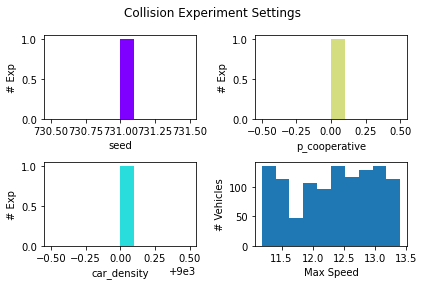

In [13]:
fig, axs = plt.subplots(2,2)
collision_params = [all_params[exp_i] for exp_i in range(len(all_trajs)) if check_collision_experiment(all_trajs[exp_i])]    

color=iter(plt.cm.rainbow(np.linspace(0,1,4)))
counter = 0
for param_key in ["seed", "car_density", "p_cooperative"]:
    row = counter%2
    col = counter // 2
    ax = axs[row, col]
    all_p_key = [param[param_key] for param in collision_params]
    c = next(color)
    ax.hist(all_p_key, facecolor=c)
    ax.set_xlabel(param_key)
    ax.set_ylabel("# Exp")
    counter+=1

    
    
c = next(color)    
all_max_speeds = [veh.max_v for vehicles in all_vehicles for veh in vehicles ]
axs[1,1].hist(all_max_speeds)
axs[1,1].set_xlabel('Max Speed')
axs[1,1].set_ylabel('# Vehicles')
fig.suptitle("Collision Experiment Settings")

fig.tight_layout()
fig.show()

# Analyze Performance of Vehicles

In [22]:
noncollision_expi = [exp_i for exp_i in range(len(all_trajs)) if not check_collision_experiment(all_trajs[exp_i])]

density_array = np.array([all_params[exi]['car_density'] for exi in noncollision_expi])
seed_array = np.array([all_params[exi]['seed'] for exi in noncollision_expi])
p_coop_array = np.array([all_params[exi]['p_cooperative'] for exi in noncollision_expi])
distances_array = np.array([all_trajs[exi][:,0,n_mpc_end] - all_trajs[exi][:,0,0] for exi in noncollision_expi])
passing_array = np.array([n_vehicles_behind(all_trajs[exi][:,0,n_mpc_end]) - n_vehicles_behind(all_trajs[exi][:,0,0]) for exi in noncollision_expi])
max_v_array = np.array([np.array([v.max_v for v in all_vehicles[exi]]) for exi in noncollision_expi])
avg_v_array = np.array([np.mean(all_trajs[exi][:,4,:n_mpc_end], axis=1) for exi in noncollision_expi])
perc_max_v_array = avg_v_array/max_v_array

p_distance_dict = {}
p_passing_dict = {}
for exi in range(distances_array.shape[0]):
    if p_coop_array[exi] not in p_distance_dict:
        p_distance_dict[p_coop_array[exi]] = []
    p_distance_dict[p_coop_array[exi]] += [distances_array[exi]]
    
    if p_coop_array[exi] not in p_passing_dict:
        p_passing_dict[p_coop_array[exi]] = []
    p_passing_dict[p_coop_array[exi]] += [passing_array[exi]]
    
for p in p_distance_dict:
    p_distance_dict[p] = np.array(p_distance_dict[p])
for p in p_passing_dict:
    p_passing_dict[p] = np.array(p_passing_dict[p])
p_unique = np.array(list(p_distance_dict.keys()))
p_unique = np.sort(p_unique)
print("Unique P_coop",p_unique)

Unique P_coop [0.  0.2 0.4 0.6 0.8 1. ]


In [23]:
def collapse(x, y, sort=True):
    ''' Input:  x: m x 1 array with n different catetories
                y: m x 1 array with values
        Output: x_coll: n x 1 array of distinct x values
                y_coll: n x 1 array of mean values for each x_coll'''
        
    
    x_coll = np.unique(x)
    if sort:
        x_coll = np.sort(x_coll)
    
    y_coll = []
    means = []
    medians = []
    std_devs = []
    
    y_coll = [y[x == x_i] for x_i in x_coll]

    
    means = np.array([np.mean(y) for y in y_coll])
    medians = np.array([np.median(y) for y in y_coll])
    std_devs = np.array([np.std(y) for y in y_coll])
    
    
    return x_coll, y_coll, means, medians, std_devs

## Distance Traveled Averaged Over Vehicles + Experiments

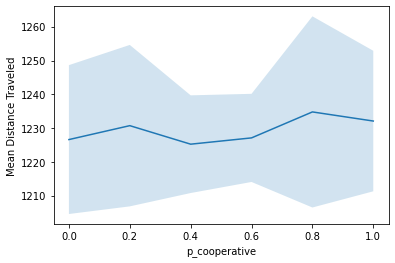

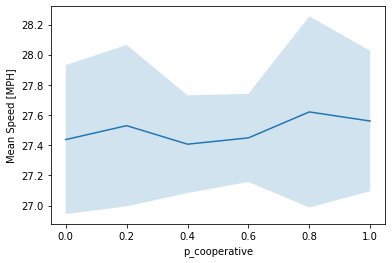

In [24]:
p_unique, avg_speeds_by_p, means, medians, std_devs = collapse(p_coop_array, np.mean(distances_array, axis=1))

# means = np.array([np.mean(p_distance_dict[p][p_distance_dict[p]>0],axis=0) for p in p_unique])
# std_devs = np.array([np.std(p_distance_dict[p][p_distance_dict[p]>0],axis=0) for p in p_unique])
plt.plot([p for p in p_unique], means, '-')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)

plt.xlabel('p_cooperative')
plt.ylabel('Mean Distance Traveled')
plt.show()

p_unique, avg_speedsmph_by_p, means, medians, std_devs = collapse(p_coop_array, np.mean(distances_array, axis=1)/total_time*CONV_MS_TO_MPH)
plt.plot([p for p in p_unique], means, '-')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)



plt.xlabel('p_cooperative')
plt.ylabel('Mean Speed [MPH]')
plt.show()

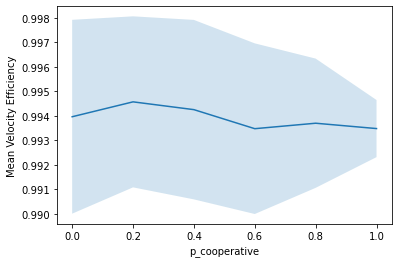

In [25]:
avg_veff = np.mean(perc_max_v_array, axis=1)
p_unique, avg_eff_by_p, means, medians, std_devs = collapse(p_coop_array, avg_veff)

plt.plot([p for p in p_unique], means, '-')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)

plt.xlabel('p_cooperative')
plt.ylabel('Mean Velocity Efficiency')
plt.show()

Densities [2500 5000 9000]


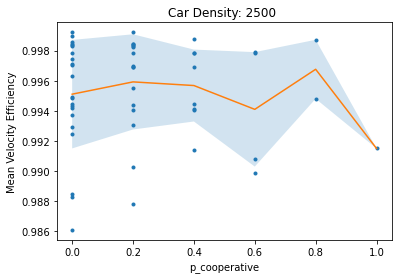

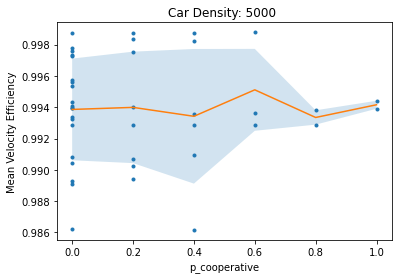

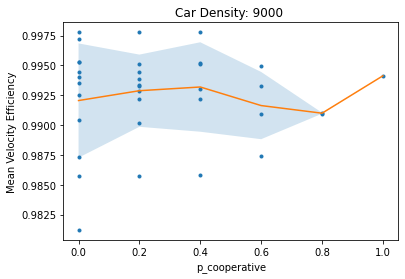

In [26]:
unique_densities = np.sort(np.unique(density_array))
print("Densities", unique_densities)

for d in unique_densities:
    p_coop_d = p_coop_array[density_array == d]
    avg_veff = np.mean(perc_max_v_array, axis=1)
    perc_max_v_d = avg_veff[density_array == d]
    x, y, means, medians, std_devs = collapse(p_coop_d, perc_max_v_d)

    plt.plot(p_coop_d, perc_max_v_d, '.')    
    plt.plot(x, means, '-')
    plt.fill_between(x, means-std_devs, means+std_devs, alpha=.2)
    plt.xlabel("p_cooperative")
    plt.ylabel("Mean Velocity Efficiency")
    plt.title("Car Density: %d "%d)
    plt.show()
    

In [204]:
print(all_params[0].keys())
for i in range(len(all_params)):
#     print(all_params[i]["car_density"])
    if all_params[i]["car_density"] == 2500:
        print(all_dirs[i])

dict_keys(['load_log_dir', 'log_subdir', 'n_processors', 'mpc_start_iteration', 'save_solver_input', 'seed', 'car_density', 'n_other', 'n_lanes', 'random_svo', 'svo_theta', 'n_mpc', 'plot_flag', 'print_flag', 'T', 'dt', 'p_exec', 'n_ibr', 'n_cntrld', 'rnds_shrd_cntrl', 'shrd_cntrl_scheduler', 'k_solve_amb_max_ibr', 'plan_fake_ambulance', 'save_ibr', 'save_state', 'default_n_warm_starts', 'k_max_slack', 'k_max_solve_number', 'k_max_round_with_slack', 'k_slack_d', 'k_CA_d', 'k_CA_power', 'wall_CA', 'print_level', 'k_lat', 'k_politeness', 'safety_constraint', 'my_task_id', 'num_tasks', 'experiment_random_seed', 'input_params', 'results_dir', 'n_experiments', 'p_cooperative', 'start_time_string', 'N', 'number_ctrl_pts_executed', 'pid'])
/home/nbuckman/mpc_results/rl_results_11102021/results/a40c-44fd-20211110-104940
/home/nbuckman/mpc_results/rl_results_11102021/results/9126-2g3h-20211110-114936
/home/nbuckman/mpc_results/rl_results_11102021/results/c3f4-1895-20211110-171125
/home/nbuckman

# Everyone

In [ ]:
means = np.array([np.mean(np.mean(p_distance_dict[p][:,:]/total_time*CONV_MS_TO_MPH,axis=1),axis=0) for p in p_unique])
std_devs = np.array([np.std(np.mean(p_distance_dict[p][:,:]/total_time*CONV_MS_TO_MPH,axis=1),axis=0) for p in p_unique])
plt.plot([p for p in p_unique], means, '-', label='All vehicles')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)

plt.xlabel('Proportion Vehicles Cooperative')
plt.ylabel('Mean Speed (MPH)')
plt.legend()
plt.show()

## Direct Comparisons

# New:  Reduced by Seed #

In [ ]:
p_coop_array = np.array([all_params[exi]['p_cooperative'] for exi in range(len(all_params))])
distances_array = np.array([all_trajs[exi][:,0,n_mpc_end] - all_trajs[exi][:,0,0] for exi in range(len(all_params))])
passing_array = np.array([np.sum(all_trajs[exi][0,0,n_mpc_end] > all_trajs[exi][:,0,n_mpc_end]) for exi in range(len(all_params))])

p_passing_seed = {}
for exi in range(passing_array.shape[0]):
    if p_coop_array[exi] not in p_distance_dict:
        p_distance_dict[p_coop_array[exi]] = []
    p_distance_dict[p_coop_array[exi]] += [distances_array[exi]]
    
    if p_coop_array[exi] not in p_passing_dict:
        p_passing_dict[p_coop_array[exi]] = []
    p_passing_dict[p_coop_array[exi]] += [passing_array[exi]]
    
for p in p_distance_dict:
    p_distance_dict[p] = np.array(p_distance_dict[p])
for p in p_passing_dict:
    p_passing_dict[p] = np.array(p_passing_dict[p])
p_unique = np.array(list(p_distance_dict.keys()))
p_unique = np.sort(p_unique)



seed_pcoop_distances = {}
seed_pcoop_passing = {}

for exi in range(len(all_params)):
    seed = all_params[exi]['seed']
    p_coop = all_params[exi]['p_cooperative']
    distances_array = np.array([all_trajs[exi][:,0,n_mpc_end] - all_trajs[exi][:,0,0]])
    passing_array = np.sum(all_trajs[exi][0,0,n_mpc_end] > all_trajs[exi][:,0,n_mpc_end])
    
    if seed not in seed_pcoop_distances:
        seed_pcoop_distances[seed] = {}
        seed_pcoop_passing[seed] = {}
    if p_coop not in seed_pcoop_distances[seed]:
        seed_pcoop_distances[seed][p_coop] = []
        seed_pcoop_passing[seed][p_coop] = []
        
    seed_pcoop_distances[seed][p_coop] += [distances_array]
    seed_pcoop_passing[seed][p_coop] += [passing_array]

for seed in seed_pcoop_distances:
    for p_coop in seed_pcoop_distances[seed]:
        seed_pcoop_distances[seed][p_coop] = np.array(seed_pcoop_distances[seed][p_coop])
        seed_pcoop_passing[seed][p_coop] = np.array(seed_pcoop_passing[seed][p_coop])
    
    
## Generate dictionary of speedups
pcoop_distances_seed = {}
pcoop_passing_seed = {}
for seed in seed_pcoop_distances:
    baseline_p = 0
    if baseline_p not in seed_pcoop_distances[seed]:
        continue
    
    baseline_dist = np.mean(seed_pcoop_distances[seed][baseline_p][:, 0, 0])
    baseline_passing = np.mean(seed_pcoop_passing[seed][baseline_p][:])
    
    for p in seed_pcoop_distances[seed]:
        avg_dist = np.mean(seed_pcoop_distances[seed][p][:, 0, 0])
        delta_dist = avg_dist - baseline_dist
        delta_passing = np.mean(seed_pcoop_passing[seed][p][:]) - baseline_passing
        if p not in pcoop_distances_seed:
            pcoop_distances_seed[p] = []
            pcoop_passing_seed[p] = []
            
        pcoop_distances_seed[p] += [delta_dist]
        pcoop_passing_seed[p] += [delta_passing]

        
for p in pcoop_distances_seed:
    pcoop_distances_seed[p] = np.array(pcoop_distances_seed[p])
    pcoop_passing_seed[p] = np.array(pcoop_passing_seed[p])
p_unique_seed = np.array([p for p in pcoop_distances_seed])
p_unique_seed.sort()





In [ ]:
print("# Experiments: %d"%len(pcoop_distances_seed[0.0]))

In [ ]:
means = np.array([np.mean(pcoop_distances_seed[p][:]) for p in p_unique])
std_devs = np.array([np.std(pcoop_distances_seed[p][:]) for p in p_unique])
plt.plot([p for p in p_unique], means, '-')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)
# plt.plot([p for p in p_unique], [np.mean(p_distance_dict[p][:,0]) for p in p_unique], 'o')
plt.hlines(0, 0, 1.0, linestyle='dotted', color='blue', label="Baseline")

plt.xlabel('p_cooperative')
plt.ylabel('Increase in Ambulance Distance Traveled')
plt.show()


means = np.array([np.mean(pcoop_distances_seed[p][:]/total_time*CONV_MS_TO_MPH) for p in p_unique])
std_devs = np.array([np.std(pcoop_distances_seed[p][:]/total_time*CONV_MS_TO_MPH) for p in p_unique])
plt.plot([p for p in p_unique], means, '-')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)
plt.hlines(0, 0, 1.0, linestyle='dotted', color='blue', label="Baseline")

# plt.plot([p for p in p_unique], [np.mean(p_distance_dict[p][:,0]) for p in p_unique], 'o')

plt.xlabel('p_cooperative')
plt.ylabel('Increase in Ambulance Average Speed')
plt.savefig('ambulance_avg_speed_increase.png',bbox_inches='tight', dpi=400)
plt.show()


means = np.array([np.mean(pcoop_passing_seed[p]) for p in p_unique])
std_devs = np.array([np.std(pcoop_passing_seed[p]) for p in p_unique])
plt.plot([p for p in p_unique], means, '-', color='green')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2, color='green')
plt.hlines(0, 0, 1.0, linestyle='dotted', color='green', label="Baseline")
# plt.plot([p for p in p_unique], [np.mean(p_distance_dict[p][:,0]) for p in p_unique], 'o')

plt.xlabel('Increase Proportion Vehicles Cooperative')
plt.ylabel('# Vehicles Passed')
plt.savefig('ambulance_veh_passing_increase.png',bbox_inches='tight', dpi=400)

plt.show()

In [ ]:
means = np.array([np.mean(pcoop_distances_seed[p][:]) for p in p_unique])
std_devs = np.array([np.std(pcoop_distances_seed[p][:]) for p in p_unique])
plt.plot([p for p in p_unique], means, '-')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)
# plt.plot([p for p in p_unique], [np.mean(p_distance_dict[p][:,0]) for p in p_unique], 'o')
plt.hlines(0, 0, 1.0, linestyle='dotted', color='blue', label="Baseline")

plt.xlabel('p_cooperative')
plt.ylabel('Increase in Ambulance Distance Traveled')
plt.show()


In [ ]:
means = np.array([np.mean(pcoop_distances_seed[p][:]) for p in p_unique])
std_devs = np.array([np.std(pcoop_distances_seed[p][:]) for p in p_unique])
plt.plot([p for p in p_unique], means, '-')
plt.fill_between([p for p in p_unique], means-std_devs, means+std_devs, alpha=.2)
# plt.plot([p for p in p_unique], [np.mean(p_distance_dict[p][:,0]) for p in p_unique], 'o')
plt.hlines(0, 0, 1.0, linestyle='dotted', color='blue', label="Baseline")

plt.xlabel('p_cooperative')
plt.ylabel('Increase in Ambulance Distance Traveled')
plt.show()
